# Compute the minimised free energy for a given correlation matrix
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
Script that takes as input the pruned correlation matrix, f.e. generated from a time series set, and gives as output:
- The subject ID
- The analytical max(S)
- The analytical min(U)
- The optimised min(F) for a range of temperatures (so a list of scalars)
- The probability distribution p for each optimised F (so a list of lists)

Note: if I want to include the pruning of the matrix, I have to give as input the original timeseries from which the correlation matrix and phase randomised can be generated, and then the pruned one consecutively.

In [2]:
# Import necessary libraries
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd

# Import external background functions
%run Week_18_functions.py

C:\Users\cyril\AppData\Local\Temp\ipykernel_10484\2871127280.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [285]:
# Import HCP data to test the script
path = glob.glob('Pruned_data_HCPAging\REST1\*.txt')

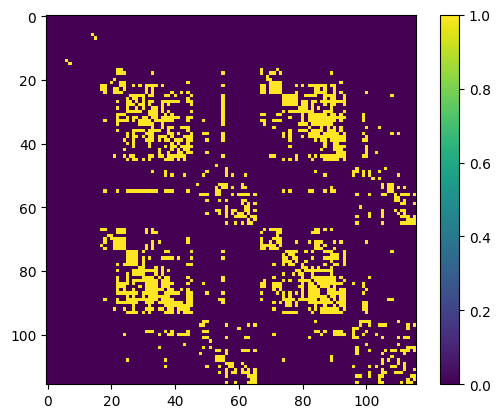

In [368]:
matrix = np.loadtxt('Cyril\prunned_matrix.txt')
matrix = matrix - np.eye(len(matrix),len(matrix))
plt.imshow(matrix)
plt.colorbar()
plt.show()

In [370]:
density = np.sum(matrix)/(len(matrix)**2)
print(f'The density of the pruned matrix is {density:.2f}')

The density of the pruned matrix is 0.11


In [ ]:
%time complete_f_generator('Cyril\prunned_matrix.txt', 3)

In [367]:
def complete_f_generator(file, max_dim):
    # Import datafile as matrix
    matrix = np.loadtxt(file)

    # Extract patient ID from filename
    identification_code = 'no HCA found'
    parts = file.split('_')
    for part in parts:
        if part.startswith("HCA"):
            identification_code = part[3:]
            break

    # Generate connection matrix and inverse
    clique_complex =  build_clique_complex(matrix, max_dim)
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_per_T = []
    p_per_T = []
    temperature_list = [0.5] #One temperature for now, to look at a range use here: np.arange(0, 1, 1)

    for temperature in temperature_list:
        free_energy_history, f_probabilities = free_energy_minimisation(clique_complex, inverse_connectivity_matrix, 1000, temperature)
        f_per_T.append(free_energy_history[-1])
        p_per_T.append(f_probabilities)

    return [identification_code, max_entropy_value, min_energy_value, f_per_T, p_per_T, temperature_list]

In [315]:
# Create an empty DataFrame with specified columns
df = pd.DataFrame(columns=['identification_code', 'max_entropy', 'min_energy', 'F_per_T', 'p_per_T', 'temperatures'])
max_clique_size = 3

for file in path[:5]:
    F = complete_f_generator(file, 3)
    # Append the list as a new row to the DataFrame
    df.loc[len(df)] = F

In [316]:
df

,identification_code,max_entropy,min_energy,F_per_T,p_per_T,temperatures
0,6002236,7.727920,0.000445,[-3.605230048361686],"[[0.0038152903066105766, 0.008750248076188152,...",[0.5]
1,6010538,7.781360,0.000334,[-3.618612886073435],"[[0.008451894160299072, 0.00024010290111203795...",[0.5]
2,6018857,7.768184,0.000401,[-3.6057797466705055],"[[0.009318305200515948, 0.006174028332138782, ...",[0.5]
3,6030645,7.714246,0.000512,[-3.6164519435879936],"[[0.0050151980903812236, 0.009482490728001178,...",[0.5]
4,6047359,7.727920,0.000438,[-3.6123397956186487],"[[0.002031845934579866, 0.0049611475408255865,...",[0.5]


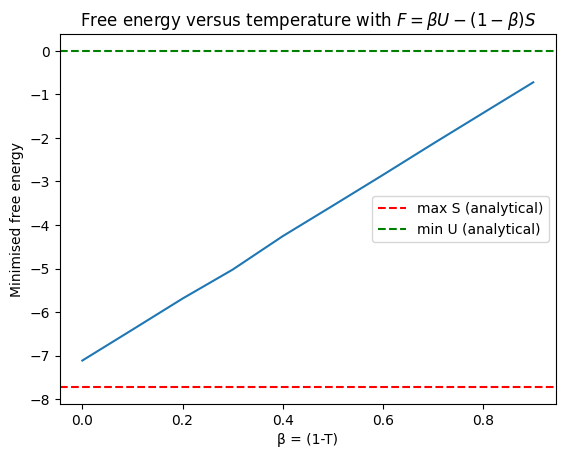

In [288]:
plt.plot(F[5], F[3])
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-F[1], color='r', linestyle='--', label='max S (analytical)')
plt.axhline(y=F[2], color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

Preprocess the data to prepare as input for Pierre's code

In [3]:
df = pd.read_csv('Cyril\\100206_rfMRI_REST1_Atlas_MSMAll_hp2000_clean_Schaefer2018_100Parcels_7Networks_Tian_Subcortex_S1_3T.txt', sep='\t', header=None)

In [5]:
# Initialize an empty DataFrame to hold discretized values
discretized_time_series = pd.DataFrame()

# Iterate over each column of 'df'
for col in df.columns:
    data = df[col].tolist()
    hist, bin_edges = np.histogram(data, bins=16)
    bin_numbers = np.digitize(data, bin_edges[:-1])
    
    # Create a DataFrame with the current column's discretized values
    col_df = pd.DataFrame({col: bin_numbers}, index=df.index)
    
    # Concatenate the new DataFrame along the columns axis
    discretized_time_series = pd.concat([discretized_time_series, col_df], axis=1)

In [6]:
discretized_time_series

,0,1,2,3,4,5,6,7,8,9,...,2390,2391,2392,2393,2394,2395,2396,2397,2398,2399
0,8,7,8,4,6,5,8,8,12,11,...,7,7,5,5,8,12,8,5,2,3
1,7,9,7,10,7,6,10,11,12,12,...,5,6,6,5,11,11,7,6,5,5
2,7,6,8,7,8,6,8,10,11,12,...,7,7,4,6,8,13,8,10,4,3
3,9,9,7,7,9,8,9,10,11,11,...,7,7,6,6,7,11,8,7,4,4
4,7,4,4,1,7,4,7,7,11,12,...,5,6,7,7,12,7,6,6,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,5,4,2,2,6,6,6,7,11,11,...,6,7,6,5,5,8,6,8,8,3
112,9,7,3,1,4,5,6,7,11,10,...,7,8,8,5,5,11,11,8,7,5
113,12,8,3,6,6,7,8,6,7,7,...,4,4,3,3,8,13,13,9,13,9
114,8,5,6,4,7,5,5,9,12,9,...,7,3,2,4,7,7,9,8,5,4


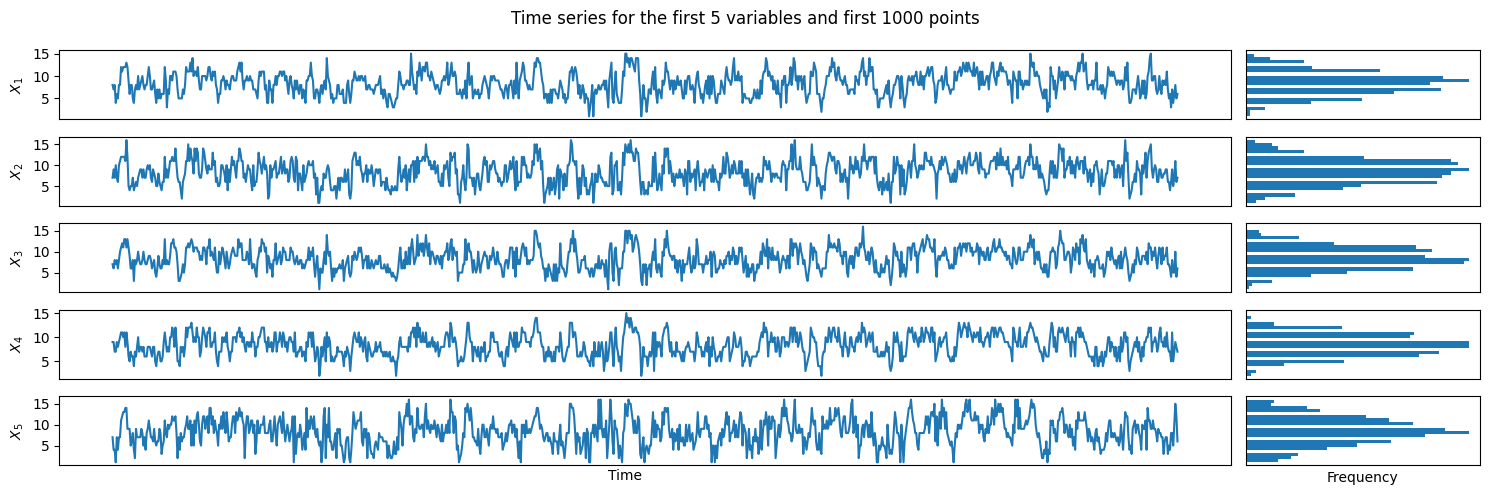

In [75]:
# Example DataFrame creation for demonstration
df = discretized_time_series.T[:1000]

# Determine the number of subplots to create
num_subplots = min(len(df.columns), 5)

# Plotting
fig, axes = plt.subplots(nrows=num_subplots, ncols=2, figsize=(15, 5), 
                         gridspec_kw={'width_ratios': [5, 1]})  # Adjust width ratios

# Plot each variable on its subplot and histogram next to it
for i, col in enumerate(df.columns[:num_subplots]):  # Limit to num_subplots
    # Plot time series
    axes[i, 0].plot(df.index, df[col])
    axes[i, 0].set_ylabel(f'$X_{col+1}$')
    axes[i, 0].set_xticks([])  # Remove x-axis ticks
    
    # Plot histogram
    axes[i, 1].hist(df[col], bins=20, orientation='horizontal')
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# Adjust layout
plt.suptitle('Time series for the first 5 variables and first 1000 points')
plt.xlabel('Frequency')
fig.text(0.42, 0.04, 'Time', ha='center')
plt.tight_layout()

# Display plot
plt.show()


In [77]:
np.savetxt('discretized_time_series.txt',discretized_time_series.T)

In [91]:
discretized_time_series = pd.read_csv('discretized_time_series.txt', sep=' ', header=None)

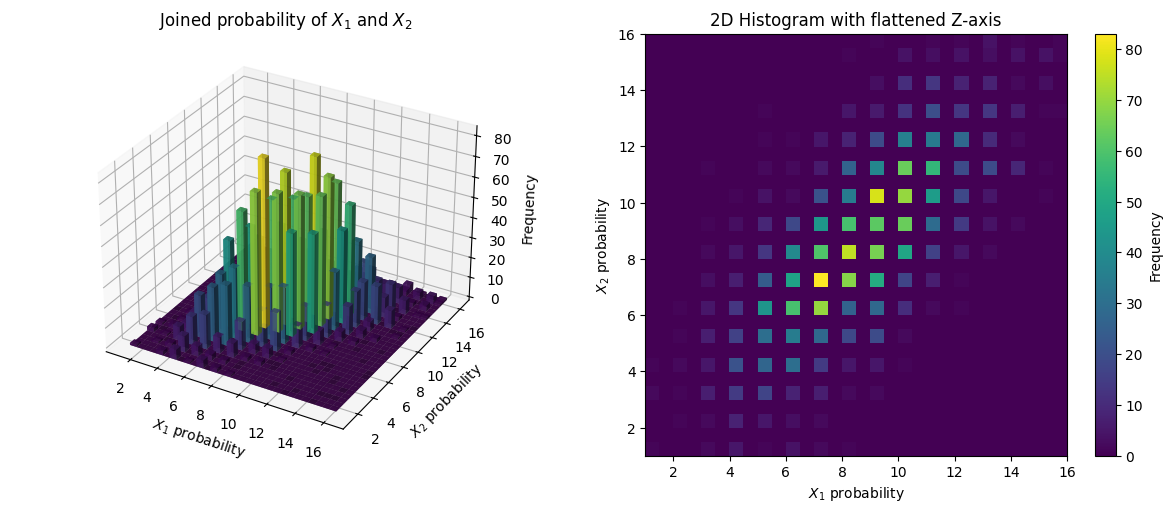

In [113]:
# Example for two correlations
x = discretized_time_series.iloc[:, 0].tolist()
y = discretized_time_series.iloc[:, 1].tolist()

# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot 3D histogram
ax1 = fig.add_subplot(121, projection='3d')
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=plt.cm.viridis(dz / dz.max()), alpha=0.8)
ax1.set_xlabel('$X_1$ probability')
ax1.set_ylabel('$X_2$ probability')
ax1.set_zlabel('Frequency')
ax1.set_title('Joined probability of $X_1$ and $X_2$')

# Plot 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
img = ax[1].imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='viridis')
ax[1].set_xlabel('$X_1$ probability')
ax[1].set_ylabel('$X_2$ probability')
ax[1].set_title('2D Histogram with flattened Z-axis')

# Figure specs
plt.colorbar(img, ax=ax[1], label='Frequency')
ax[0].axis('off')
plt.tight_layout()
plt.show()


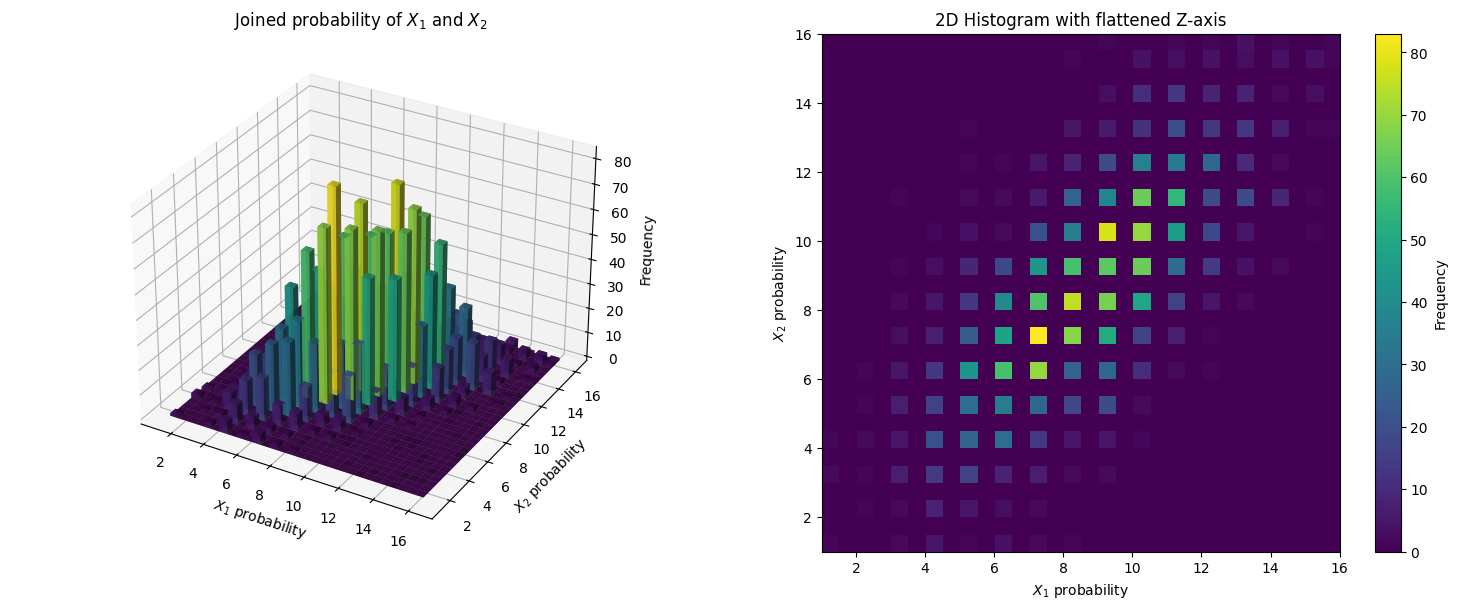

In [114]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
x = discretized_time_series.iloc[:, 0].tolist()
y = discretized_time_series.iloc[:, 1].tolist()

# Create figure and subplots with larger figsize
fig, ax = plt.subplots(1, 2, figsize=(15, 6))  # Adjust figsize as needed

# Plot 3D histogram
ax1 = fig.add_subplot(121, projection='3d')
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25, indexing="ij")
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)
dx = dy = 0.5 * np.ones_like(zpos)
dz = hist.ravel()
ax1.bar3d(xpos, ypos, zpos, dx, dy, dz, zsort='average', color=plt.cm.viridis(dz / dz.max()), alpha=0.8)
ax1.set_xlabel('$X_1$ probability')
ax1.set_ylabel('$X_2$ probability')
ax1.set_zlabel('Frequency')
ax1.set_title('Joined probability of $X_1$ and $X_2$')

# Plot 2D histogram
hist, xedges, yedges = np.histogram2d(x, y, bins=30)
img = ax[1].imshow(hist.T, extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], origin='lower', cmap='viridis')
ax[1].set_xlabel('$X_1$ probability')
ax[1].set_ylabel('$X_2$ probability')
ax[1].set_title('2D Histogram with flattened Z-axis')

# Add colorbar using the mappable object
plt.colorbar(img, ax=ax[1], label='Frequency')

# Hide the axes of the subplot behind the 3D plot
ax[0].axis('off')

# Adjust layout
plt.tight_layout()

# Display plot
plt.show()
